In [1]:
import pandas as pd, numpy as np, seaborn as sns
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier, BaggingClassifier, VotingRegressor, BaggingRegressor
from mlxtend.classifier import StackingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import set_config
set_config(display="diagram")

In [355]:
csv='pipeline_3sets_nbgames.pickle'
csv.split('_')

['pipeline', '3sets', 'nbgames.pickle']

### Preprocessing

In [166]:
df = pd.read_csv('atp.csv')
df.head(3)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames,L2M,Month,SumOdd,SumRank
0,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Johansson T.,Pretzsch A.,7.0,133.0,7.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.100,6.500,0,0.0,126.0,5.400,2.0,13.0,6.0,19.0,0,6,7.600,140.0
1,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Kafelnikov Y.,Bjorkman J.,6.0,56.0,7.0,6.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.444,2.625,0,0.0,50.0,1.181,2.0,13.0,8.0,21.0,0,6,4.069,62.0
2,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Koubek S.,Moya C.,41.0,20.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,2.625,1.444,1,1.0,21.0,1.181,2.0,12.0,6.0,18.0,0,6,4.069,61.0


In [167]:
df['W3'] = df['W3'].replace(' ', np.nan)
df['L3'] = df['L3'].replace(' ', np.nan)
df['W3']=df['W3'].astype('float')
df['L3']=df['L3'].astype('float')

In [168]:
df['SumOdd']=df['B365L']+df['B365W']
df['SumRank']=df['LRank']+df['WRank']
df.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames,L2M,Month,SumOdd,SumRank
0,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Johansson T.,Pretzsch A.,7.0,133.0,7.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.100,6.500,0,0.0,126.0,5.400,2.0,13.0,6.0,19.0,0,6,7.600,140.0
1,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Kafelnikov Y.,Bjorkman J.,6.0,56.0,7.0,6.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.444,2.625,0,0.0,50.0,1.181,2.0,13.0,8.0,21.0,0,6,4.069,62.0
2,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Koubek S.,Moya C.,41.0,20.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,2.625,1.444,1,1.0,21.0,1.181,2.0,12.0,6.0,18.0,0,6,4.069,61.0
3,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Pavel A.,Stepanek R.,21.0,150.0,7.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.533,2.375,0,0.0,129.0,0.842,2.0,13.0,10.0,23.0,0,6,3.908,171.0
4,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Sampras P.,Stoliarov A.,13.0,107.0,4.0,6.0,6.0,3.0,6.0,4.0,NaN,NaN,NaN,NaN,2.0,1.0,Completed,1.143,5.000,0,0.0,94.0,3.857,3.0,10.0,9.0,19.0,1,6,6.143,120.0


In [169]:
df.loc[df['Series'] == 'Grand Slam', 'Best of'] = 5

In [170]:
df3=df[df['Best of']==3]
df5=df[df['Best of']==5]
df.to_csv('atp.csv', index=False)
df3.to_csv('atp_3sets.csv', index=False)
df5.to_csv('atp_5sets.csv', index=False)

In [93]:
df=pd.read_csv('atp_3sets.csv')
df.head(3)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames,L2M,Month,SumOdd,SumRank
0,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Johansson T.,Pretzsch A.,7.0,133.0,7.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.100,6.500,0,0.0,126.0,5.400,2.0,13.0,6.0,19.0,0,6,7.600,140.0
1,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Kafelnikov Y.,Bjorkman J.,6.0,56.0,7.0,6.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.444,2.625,0,0.0,50.0,1.181,2.0,13.0,8.0,21.0,0,6,4.069,62.0
2,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Koubek S.,Moya C.,41.0,20.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,2.625,1.444,1,1.0,21.0,1.181,2.0,12.0,6.0,18.0,0,6,4.069,61.0


In [155]:
df.describe()

,ATP,Best of,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,B365W,B365L,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames,L2M,Month,SumOdd,SumRank
count,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,24187.000000,24187.000000,4897.000000,4897.000000,1864.000000,1864.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000,50517.000000
mean,32.945345,3.387751,57.282875,89.496823,5.815963,4.098383,5.820239,3.946335,6.062926,3.661140,5.810292,3.912395,6.611588,3.763412,2.193697,0.418730,1.818825,3.501273,0.341806,0.299602,69.601164,2.526549,2.612427,12.443474,8.562939,21.006414,0.381852,5.647089,5.320098,146.779698
std,18.049636,0.790673,69.878380,110.334539,1.222302,1.823780,1.198494,1.843464,0.865040,1.751288,1.234939,1.873197,1.625876,2.303427,0.395198,0.563169,1.094325,3.388946,0.474320,0.451669,107.306330,3.444909,0.760686,2.753412,3.500458,5.431984,0.485845,2.978352,3.153524,137.084242
min,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,0.000000,0.971000,0.967000,0.000000,0.000000,1.000000,0.000000,2.000000,6.000000,0.000000,12.000000,0.000000,1.000000,2.200000,3.000000
25%,19.000000,3.000000,16.000000,35.000000,6.000000,3.000000,6.000000,3.000000,6.000000,2.000000,6.000000,2.000000,6.000000,2.000000,2.000000,0.000000,1.250000,1.720000,0.000000,0.000000,18.000000,0.680000,2.000000,12.000000,6.000000,18.000000,0.000000,3.000000,3.860000,70.000000
50%,33.000000,3.000000,41.000000,64.000000,6.000000,4.000000,6.000000,4.000000,6.000000,4.000000,6.000000,4.000000,6.000000,4.000000,2.000000,0.000000,1.500000,2.500000,0.000000,0.000000,40.000000,1.470000,2.000000,12.000000,8.000000,20.000000,0.000000,6.000000,4.230000,115.000000
75%,49.000000,3.000000,76.000000,103.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,6.000000,7.000000,5.000000,2.000000,1.000000,2.000000,3.750000,1.000000,1.000000,78.000000,3.110000,3.000000,13.000000,10.000000,22.000000,1.000000,8.000000,5.520000,177.000000
max,67.000000,5.000000,1890.000000,2159.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,26.000000,24.000000,3.000000,2.000000,34.000000,67.000000,1.000000,1.000000,2094.000000,66.000000,5.000000,45.000000,41.000000,86.000000,1.000000,12.000000,68.000000,2864.000000


### PREPROCESSING / MATCHS EN 3 SETS

In [2]:
df=pd.read_csv('atp_3sets.csv')
df.head(3)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames,L2M,Month,SumOdd,SumRank
0,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Johansson T.,Pretzsch A.,7.0,133.0,7.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.100,6.500,0,0.0,126.0,5.400,2.0,13.0,6.0,19.0,0,6,7.600,140.0
1,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Kafelnikov Y.,Bjorkman J.,6.0,56.0,7.0,6.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.444,2.625,0,0.0,50.0,1.181,2.0,13.0,8.0,21.0,0,6,4.069,62.0
2,32,Halle,Gerry Weber Open,2002-06-10,International,Outdoor,Grass,1st Round,3,Koubek S.,Moya C.,41.0,20.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,2.625,1.444,1,1.0,21.0,1.181,2.0,12.0,6.0,18.0,0,6,4.069,61.0


#### distributions & outliers

In [129]:
def multiple_boxplot(df):
  plt.figure(figsize=(18,25))
  for i in range(len(df.columns)):
    plt.subplot(8, 5, i + 1)    # define figure size and subplots numbers
    plt.boxplot(x = df[df.columns[i]])
    plt.title(df.columns[i] + ' BOXPLOT')
    
    
# multiple hist
def multiple_hist(df):
  plt.figure(figsize=(18,25))
  for i in range(len(df.columns)):
      plt.subplot(8, 5, i + 1)    # define figure size and subplots numbers
      plt.hist(x = df[df.columns[i]])
      plt.title(df.columns[i] + ' HISTOGRAM')
      
def hist_boxplot(df):
  plt.figure(figsize=(18,50))
  for col in df.columns:
    plt.subplot(len(df.columns), 2, 1)
    plt.hist(x=df[col])
    plt.title(col + ' histogram')
    plt.subplot(len(df.columns), 2, 2)
    plt.boxplot(df[col])
    plt.title(col + ' boxplot')
    
def hist_boxplot2(df):
    num_cols = len(df.columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, num_cols*3))
    for i, col in enumerate(df.columns):
      ax1 = axes[i, 0]
      ax2 = axes[i, 1]
      ax1.hist(df[col])
      ax1.set_title(col + ' histogram')
      
      ax2.boxplot(df[col])
      ax2.set_title(col + ' boxplot')
        
    plt.tight_layout()
    plt.show()


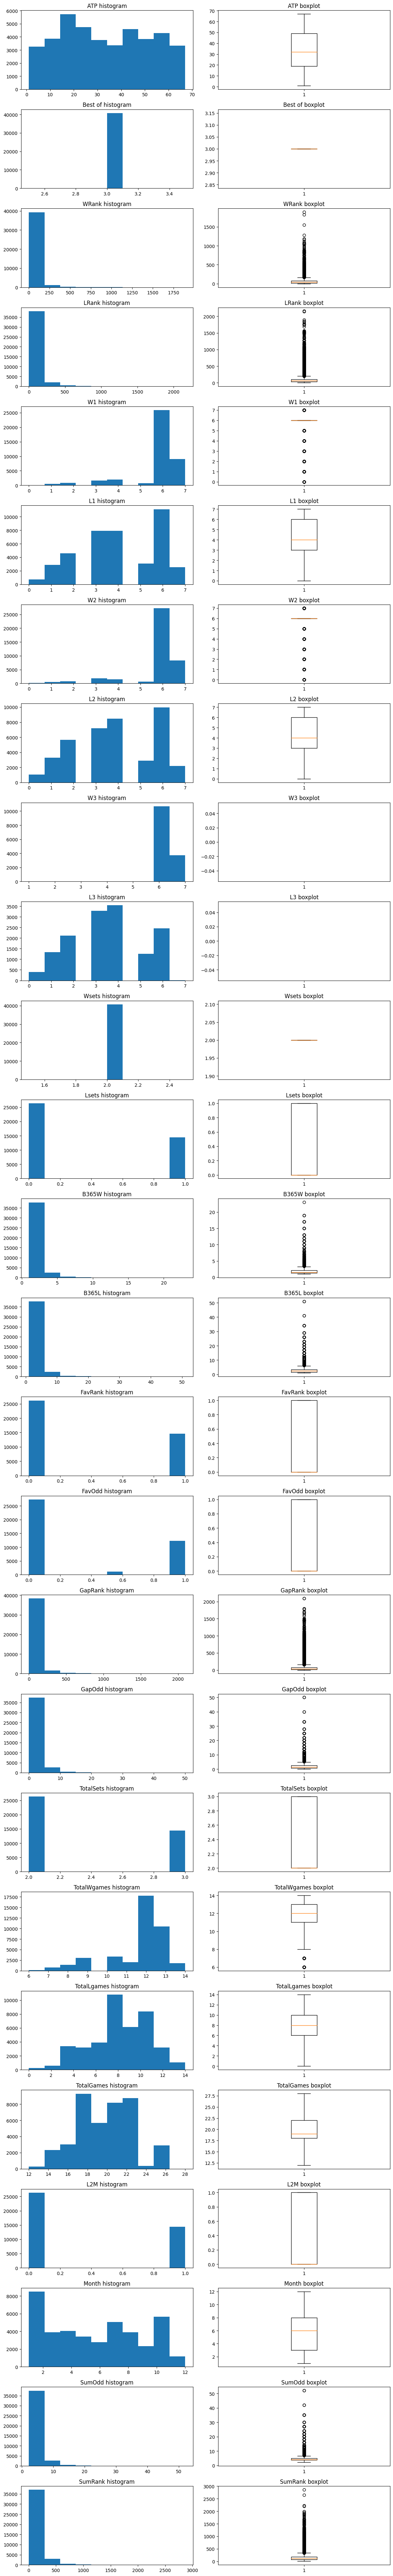

In [161]:
hist_boxplot2(df[['ATP', 'Best of', 'WRank', 'LRank', 'W1', 'L1', 'W2', 'L2', 'W3', 'L3',
       'Wsets', 'Lsets', 'B365W', 'B365L', 'FavRank',
       'FavOdd', 'GapRank', 'GapOdd', 'TotalSets', 'TotalWgames',
       'TotalLgames', 'TotalGames', 'L2M', 'Month', 'SumOdd', 'SumRank']])

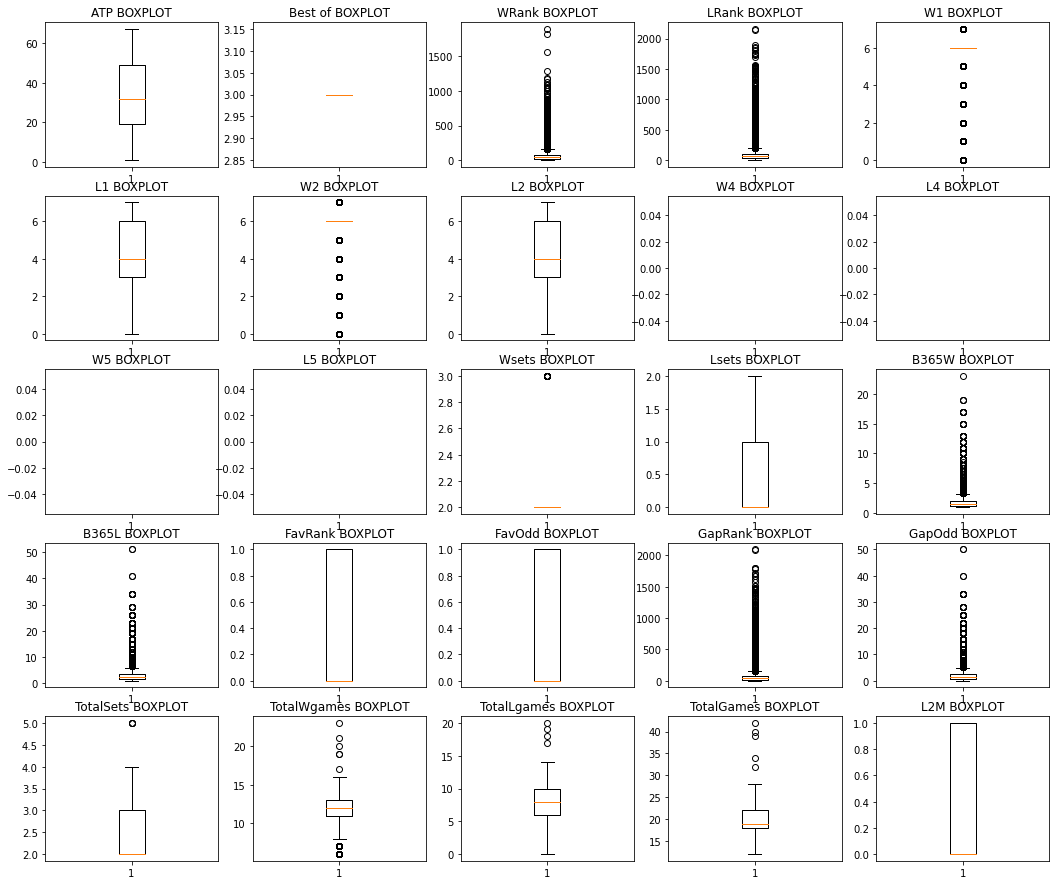

In [12]:
multiple_boxplot(df.select_dtypes(include='number'))

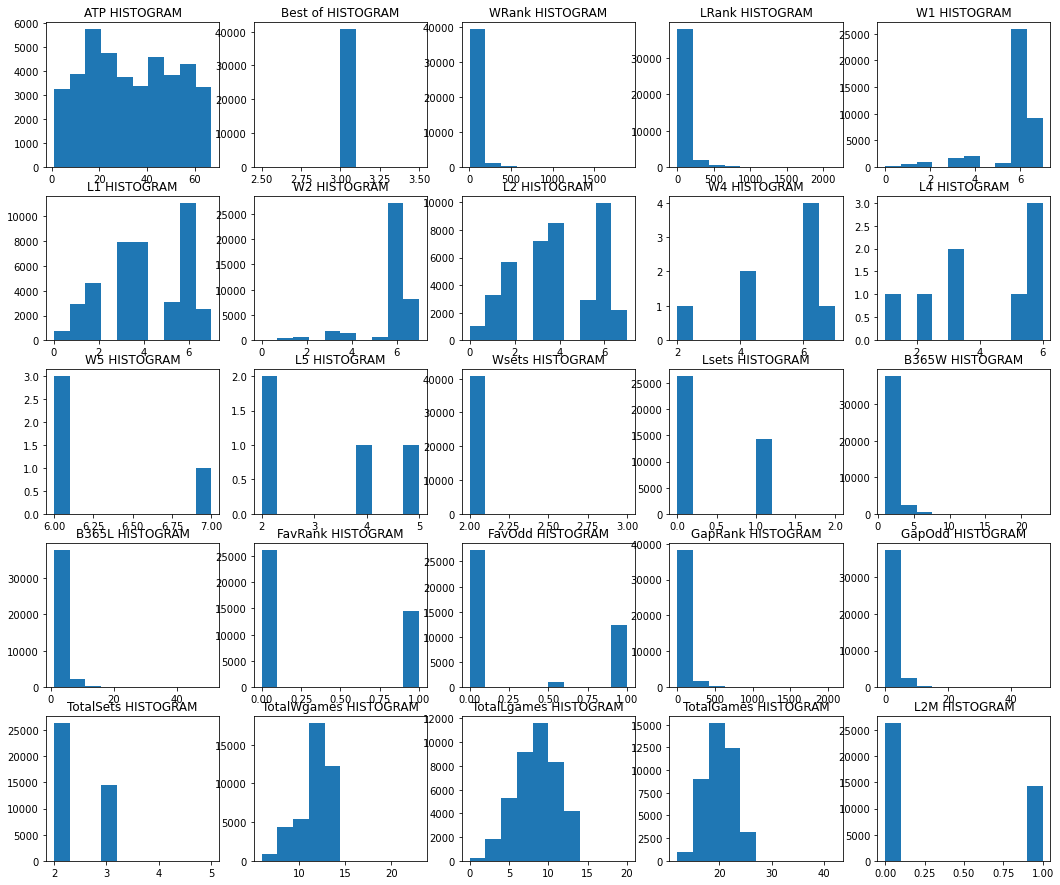

In [13]:
multiple_hist(df.select_dtypes(include='number'))

## PREDICTIONS SUR FAVRANK

### ML Regression

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.75, random_state=42)

In [ ]:
algo = SVR()

algo.fit(X_train, y_train)

print(algo.score(X_train, y_train))
print(algo.score(X_test, y_test))

### ML Classification

##### Target = FavRank (0 = FavRank gagnant, 1 = FavRank non-gagnant)

In [15]:
test=X.sample(n=1)
test

NameError: name 'X' is not defined

In [16]:
X=df.drop(columns=['Date', 'Winner', 'Loser', 'Comment', 'ATP', 'Best of', 
                   'WRank', 'LRank', 'B365W', 'B365L','W1', 'L1', 'W2', 'L2',  'W3', 'L3', 
                   'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'FavRank', 'FavOdd', 
                   'TotalSets', 'TotalGames', 'TotalWgames', 'TotalLgames', 'L2M'])

y_rank=df['FavRank']
y_odd=df['FavOdd']
y_sets=df['TotalSets']
y_games=df['TotalGames']
y_l2m=df['L2M']

In [24]:
X_train_rank, X_test_rank, y_train_rank, y_test_rank = train_test_split(X, y_rank, test_size=0.25, random_state=42)
# X_train_odd, X_test_odd, y_train_odd, y_test_odd = train_test_split(X, y_odd, test_size=0.25, random_state=42)
# X_train_sets, X_test_sets, y_train_sets, y_test_sets = train_test_split(X, y_sets, test_size=0.25, random_state=42)
# X_train_games, X_test_games, y_train_games, y_test_games = train_test_split(X, y_games, test_size=0.25, random_state=42)
# X_train_rank, X_test_rank, y_train_rank, y_test_rank = train_test_split(X, y_l2m, test_size=0.25, random_state=42)

In [26]:
base_model = DecisionTreeClassifier(max_depth=3)

algos = [LogisticRegression(), 
         DecisionTreeClassifier(), 
         KNeighborsClassifier(),
         RandomForestClassifier(), 
         AdaBoostClassifier(), 
         GradientBoostingClassifier(),
         VotingClassifier(estimators=[('knn', KNeighborsClassifier()), ('lr', LogisticRegression()), ('dt', DecisionTreeClassifier())], voting='hard'), 
         BaggingClassifier(base_estimator=DecisionTreeClassifier())]

In [27]:
score_train=[]
score_test=[]

for algo in algos:
    categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
    numeric_columns = ['GapRank', 'GapOdd']

    rob_scaler = RobustScaler()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    # Création du préprocesseur pour les colonnes numériques et catégorielles
    preprocessor = ColumnTransformer(
        transformers=[
            ('rob_scaler', rob_scaler, numeric_columns),
            ('encoder', ohe, categorical_columns)
        ])

    # Création du pipeline avec le préprocesseur et le classificateur SVC
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', algo)
    ])
    
    pipeline.fit(X_train_rank, y_train_rank)
    score_train.append(pipeline.score(X_train_rank,y_train_rank))
    score_test.append(pipeline.score(X_test_rank,y_test_rank))   

In [38]:
score_test

[0.641665030433929,
 0.5853131749460043,
 0.6078931867268801,
 0.6027881405851169,
 0.6396033771843707,
 0.6393088552915767,
 0.6293932849008443,
 0.6135872766542313]

In [29]:
score_train

[0.6510882016036655,
 0.9929307805596466,
 0.7376861397479955,
 0.9928980526918672,
 0.6487972508591066,
 0.6585828833251514,
 0.8284732449680904,
 0.9648175421371298]

#### VotingClassifier

In [40]:
algo_voting=VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()), 
    ('lr', LogisticRegression()), 
    ('dt', DecisionTreeClassifier())], 
                             voting='hard')

In [46]:
X_train_rank.columns

Index(['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'GapRank', 'GapOdd'],
      dtype='object')

In [43]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', algo_voting)
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                                              ('lr', LogisticRegression()),
                                              ('dt',
                                               DecisionTreeClassifier())]))])

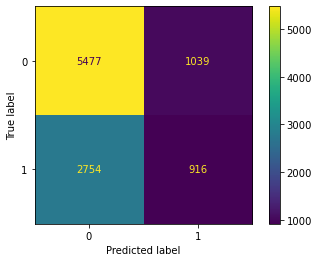

In [47]:
pipeline.fit(X_train_rank, y_train_rank)

y_test_rank_pred=pipeline.predict(X_test_rank)

pipeline.score(X_train_rank,y_train_rank)
pipeline.score(X_test_rank,y_test_rank)

ConfusionMatrixDisplay(confusion_matrix(y_test_rank,y_test_rank_pred), display_labels=pipeline.classes_).plot()

#### Stacking

KNeighborsClassifier 0.6078931867268801
LogisticRegression 0.641665030433929
DecisionTreeClassifier 0.5802081288042411
LogisticRegression 0.641665030433929
StackingClassifier 0.5811898684468879


AttributeError: 'StackingClassifier' object has no attribute 'classes_'

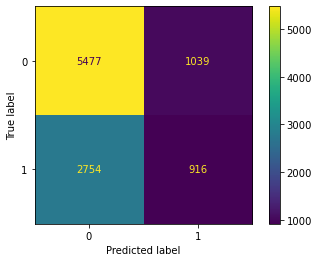

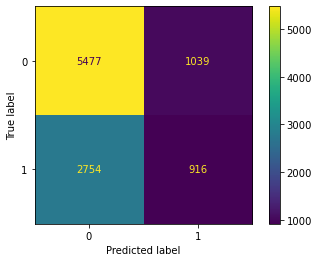

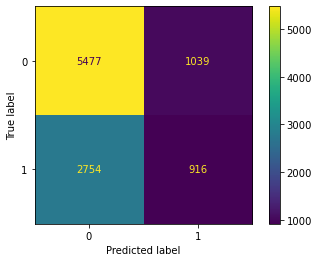

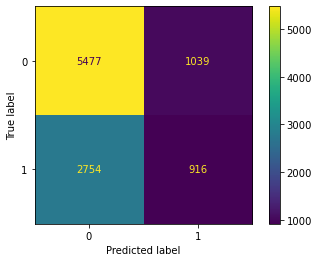

In [59]:
from mlxtend.classifier import StackingClassifier

# Initialize individual models
clf_1 = KNeighborsClassifier()
clf_2 = LogisticRegression()
clf_3 = DecisionTreeClassifier()
clf_meta = LogisticRegression() # Initialize meta-model
clf_stack = StackingClassifier(classifiers=[clf_1, clf_2, clf_3], # Create stacking classifier
                               meta_classifier=clf_meta, 
                               use_probas=False, 
                               use_features_in_secondary=False)

# Fit and predict with the models and ensemble
for clf in (clf_1, clf_2, clf_3, clf_meta, clf_stack):
   
   categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
   numeric_columns = ['GapRank', 'GapOdd']
   rob_scaler = RobustScaler()
   ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

   # Création du préprocesseur pour les colonnes numériques et catégorielles
   preprocessor = ColumnTransformer(
      transformers=[
         ('rob_scaler', rob_scaler, numeric_columns),
         ('encoder', ohe, categorical_columns)
      ])

   # Création du pipeline avec le préprocesseur et le classificateur SVC
   pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', clf)])
      
   
   pipeline.fit(X_train_rank, y_train_rank)
   y_pred = pipeline.predict(X_test_rank)
   print(clf.__class__.__name__, accuracy_score(y_test_rank, y_pred))
   ConfusionMatrixDisplay(confusion_matrix(y_test_rank,y_test_rank_pred), display_labels=pipeline.classes_).plot()

#### Boosting

In [60]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', AdaBoostClassifier())])

0.6487972508591066
0.6396033771843707


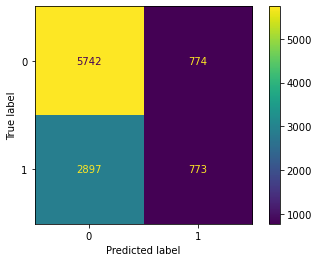

In [63]:
pipeline.fit(X_train_rank, y_train_rank)

y_test_rank_pred=pipeline.predict(X_test_rank)

print(pipeline.score(X_train_rank,y_train_rank))
print(pipeline.score(X_test_rank,y_test_rank))

ConfusionMatrixDisplay(confusion_matrix(y_test_rank,y_test_rank_pred), display_labels=pipeline.classes_).plot()

In [6]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', SVC(probability=True))])

In [7]:
pipeline_rank = pipeline.fit(X_train_rank,y_train_rank)
# pipeline_odd = pipeline.fit(X_train_odd,y_train_odd)
# pipeline_sets = pipeline.fit(X_train_sets,y_train_sets)
# pipeline_games = pipeline.fit(X_train_games,y_train_games)

In [ ]:
print(pipeline_rank.score(X_train_rank,y_train_rank))
# print(pipeline_odd.score(X_train_odd,y_train_odd))
# print(pipeline_sets.score(X_train_sets,y_train_sets))
# print(pipeline_games.score(X_train_games,y_train_games))

0.6482408771068565

In [17]:
pipeline.score(X_test, y_test)

0.6385234635774593

In [55]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('stand_scaler',
                                                  StandardScaler(),
                                                  ['TotalGames']),
                                                 ('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', SVC(probability=True))])

In [78]:
X_transf=pipeline.fit_transform(X)

In [56]:
pipeline.predict_proba(test)

array([[0.67879104, 0.32120896]])

In [39]:
df['Series'].value_counts()

ATP250                14707
International          7615
Masters 1000           7112
ATP500                 5195
Masters                3444
International Gold     2364
Masters Cup             286
Grand Slam               18
Name: Series, dtype: int64

In [57]:
# Sérialisation du modèle
with open('pipeline3sets.pickle', 'wb') as fichier:
    pickle.dump(pipeline, fichier)


In [ ]:
# Charger le modèle depuis le fichier
with open('algo_svc.pickle', 'rb') as fichier:
    algo_svc = pickle.load(fichier)


## PREDICTIONS SUR L2M

In [3]:
df.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'W1', 'L1',
       'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets',
       'Comment', 'B365W', 'B365L', 'FavRank', 'FavOdd', 'GapRank', 'GapOdd',
       'TotalSets', 'TotalWgames', 'TotalLgames', 'TotalGames', 'L2M', 'Month',
       'SumOdd', 'SumRank'],
      dtype='object')

In [3]:
X=df.drop(columns=['Date', 'Winner', 'Loser', 'Comment', 'ATP', 'Best of', 
                   'WRank', 'LRank', 'B365W', 'B365L','W1', 'L1', 'W2', 'L2',  'W3', 'L3', 
                   'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'FavRank', 'FavOdd', 
                   'TotalSets', 'TotalGames', 'TotalWgames', 'TotalLgames', 'L2M'])

# y_rank=df['FavRank']
# y_odd=df['FavOdd']
# y_sets=df['TotalSets']
# y_games=df['TotalGames']
y_l2m=df['L2M']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_l2m, test_size=0.25, random_state=42)

In [17]:
df_pred_l2m = pd.DataFrame()
df_pred_l2m['real'] = y_test

In [19]:
df_pred_l2m

,real
34606,0
5504,0
40262,0
13966,1
27479,0
...,...
23336,1
13214,1
6195,0
7628,1


In [11]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

#### VotingClassifier

In [12]:
algo_voting=VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()), 
    ('lr', LogisticRegression()), 
    ('dt', DecisionTreeClassifier())], 
                             voting='hard')

In [14]:
# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_voting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', algo_voting)
])

pipeline_voting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                                              ('lr', LogisticRegression()),
                                              ('dt',
                                               DecisionTreeClassifier())]))])

0.8069543579333377
0.6156566152637265


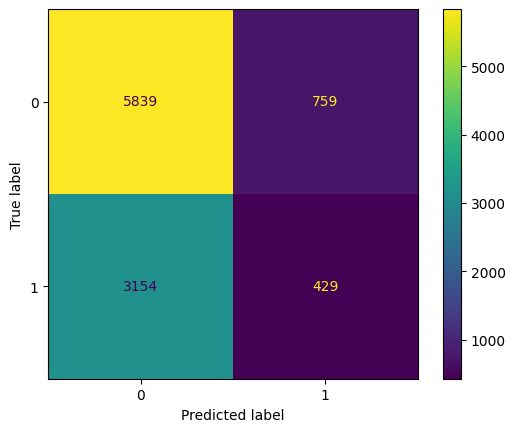

In [15]:
pipeline_voting.fit(X_train, y_train)

y_test_pred=pipeline_voting.predict(X_test)

print(pipeline_voting.score(X_train,y_train))
print(pipeline_voting.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_voting.classes_).plot()

In [20]:
df_pred_l2m['voting'] = pipeline_voting.predict(X_test)

#### LogisticRegr

In [128]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumRank', 'SumOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumRank', 'SumOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', LogisticRegression())])

0.6463230960644358
0.6464001571554857


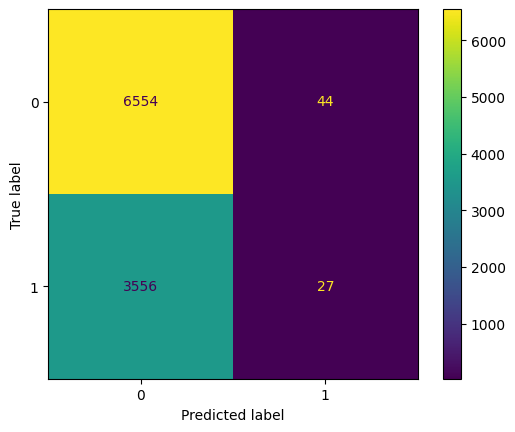

In [129]:
pipeline_lr.fit(X_train, y_train)

y_test_pred=pipeline_lr.predict(X_test)

print(pipeline_lr.score(X_train,y_train))
print(pipeline_lr.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_lr.classes_).plot()

#### Stacking

In [136]:
from mlxtend.classifier import StackingClassifier

# Initialize individual models
clf_1 = GaussianNB()
clf_2 = LogisticRegression()
clf_3 = DecisionTreeClassifier()
clf_meta = GaussianNB() # Initialize meta-model
clf_stack = StackingClassifier(classifiers=[clf_1, clf_2, clf_3], # Create stacking classifier
                               meta_classifier=clf_meta, 
                               use_probas=False, 
                               use_features_in_secondary=True)

# Fit and predict with the models and ensemble
for clf in (clf_1, clf_2, clf_3, clf_stack):
   
   categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
   numeric_columns = ['GapRank', 'GapOdd', 'SumRank', 'SumOdd']
   rob_scaler = RobustScaler()
   ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

   # Création du préprocesseur pour les colonnes numériques et catégorielles
   preprocessor = ColumnTransformer(
      transformers=[
         ('rob_scaler', rob_scaler, numeric_columns),
         ('encoder', ohe, categorical_columns)
      ])

   # Création du pipeline avec le préprocesseur et le classificateur SVC
   pipeline_stacking = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', clf)])
      
   
   pipeline_stacking.fit(X_train, y_train)
   y_pred = pipeline_stacking.predict(X_test)
   print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
   

GaussianNB 0.4721540123759945
LogisticRegression 0.6464001571554857
DecisionTreeClassifier 0.5549553089087516
StackingClassifier 0.5608486396228268


In [90]:
test=X.sample(n=1)
test

,Location,Tournament,Series,Court,Surface,Round,GapRank,GapOdd
25111,Atlanta,BB&T Atlanta Open,ATP250,Outdoor,Hard,2nd Round,60.0,1.92


#### Boosting

In [28]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_ada = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier())
])

pipeline_ada

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', AdaBoostClassifier())])

0.6465850304498723
0.6466948236911895


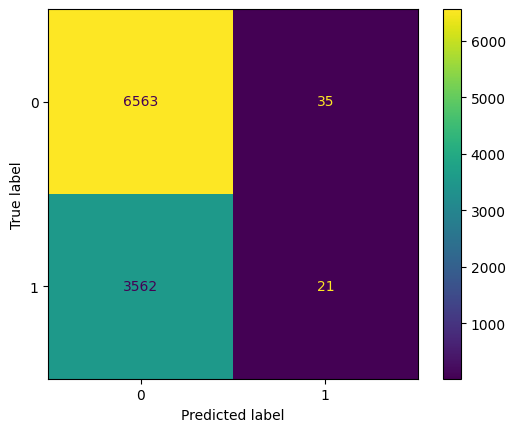

In [29]:
pipeline_ada.fit(X_train, y_train)

y_test_pred=pipeline_ada.predict(X_test)

print(pipeline_ada.score(X_train,y_train))
print(pipeline_ada.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_ada.classes_).plot()

In [30]:
df_pred_l2m['adaboost']=pipeline_ada.predict(X_test)

#### tests sur plusieurs algos

In [31]:
base_model = DecisionTreeClassifier(max_depth=3)

algos = [LogisticRegression(), 
         DecisionTreeClassifier(), 
         KNeighborsClassifier(),
         RandomForestClassifier(), 
         AdaBoostClassifier(), 
         GradientBoostingClassifier()]

In [33]:
score_train=[]
score_test=[]

for algo in algos:
    categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
    numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

    rob_scaler = RobustScaler()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    # Création du préprocesseur pour les colonnes numériques et catégorielles
    preprocessor = ColumnTransformer(
        transformers=[
            ('rob_scaler', rob_scaler, numeric_columns),
            ('encoder', ohe, categorical_columns)
        ])

    # Création du pipeline avec le préprocesseur et le classificateur SVC
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', algo)
    ])
    
    pipeline.fit(X_train, y_train)
    score_train.append(pipeline.score(X_train,y_train))
    score_test.append(pipeline.score(X_test,y_test))   

In [34]:
score_train

[0.6463230960644358,
 0.9997380656145636,
 0.7203195599502324,
 0.9997380656145636,
 0.6465850304498723,
 0.648156636762491]

In [35]:
score_test

[0.6464001571554857,
 0.554464198015912,
 0.5825557410863373,
 0.595324624300167,
 0.6466948236911895,
 0.6474806011197328]

#### Naive Bayes

In [108]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_naivebayes = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB(priors=[0.7,0.3]))
])

pipeline_naivebayes

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', GaussianNB(priors=[0.7, 0.3]))])

0.5041582083688037
0.47716334348295847


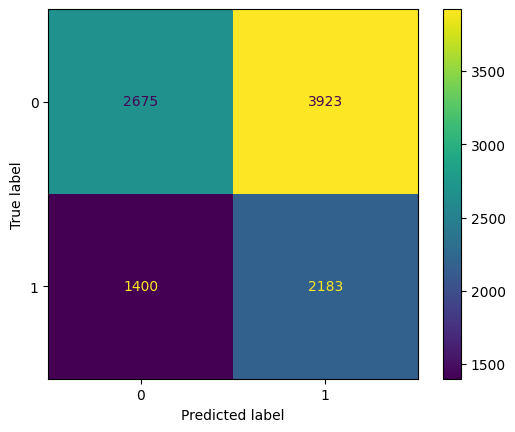

In [109]:
pipeline_naivebayes.fit(X_train, y_train)

y_test_pred=pipeline_naivebayes.predict(X_test)

print(pipeline_naivebayes.score(X_train,y_train))
print(pipeline_naivebayes.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_naivebayes.classes_).plot()

#### BernoulliNB

In [39]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_bernoulli = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BernoulliNB())
])

pipeline_bernoulli

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', BernoulliNB())])

0.6375482941523148
0.6319614969060013


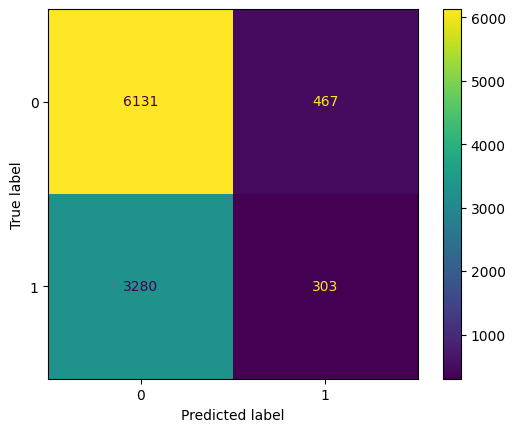

In [40]:
pipeline_bernoulli.fit(X_train, y_train)

y_test_pred=pipeline_bernoulli.predict(X_test)

print(pipeline_bernoulli.score(X_train,y_train))
print(pipeline_bernoulli.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_bernoulli.classes_).plot()

#### Bagging

In [69]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumRank', 'SumOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_bagging = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(GaussianNB()))
])

pipeline_bagging

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumRank', 'SumOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', BaggingClassifier(base_estimator=GaussianNB()))])

0.47708074127431077
0.45093802180532366


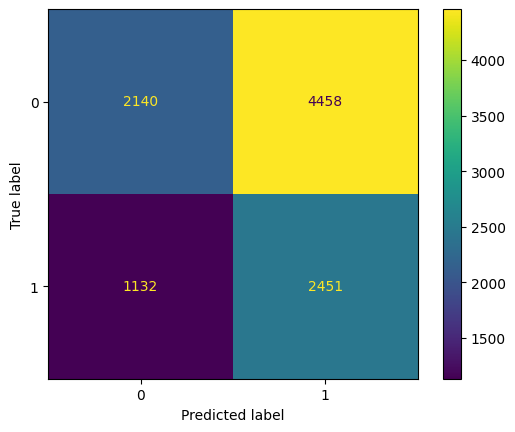

In [70]:
pipeline_bagging.fit(X_train, y_train)

y_test_pred=pipeline_bagging.predict(X_test)

print(pipeline_bagging.score(X_train,y_train))
print(pipeline_bagging.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_bagging.classes_).plot()

#### GridSearch

In [84]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Month', 'SumRank', 'SumOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])
preprocessor

ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                 ['GapRank', 'GapOdd', 'Month', 'SumRank',
                                  'SumOdd']),
                                ('encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Location', 'Tournament', 'Series', 'Court',
                                  'Surface', 'Round'])])

In [85]:
X_train_scaled=preprocessor.fit_transform(X_train)
X_test_scaled=preprocessor.transform(X_test)

In [86]:
gauss=GaussianNB()
dico_gauss={'priors' :[[0.1, 0.9],[0.2,0.8], [0.3, 0.7],[0.4,0.6]]
         }

gs= GridSearchCV(gauss, dico_gauss)

gs.fit(X_train_scaled, y_train)

GridSearchCV(estimator=GaussianNB(),
             param_grid={'priors': [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7],
                                    [0.4, 0.6]]})

In [87]:
gs.best_params_

{'priors': [0.4, 0.6]}

In [88]:
gs.best_score_

0.46277256558248786

In [89]:
gs.cv_results_

{'mean_fit_time': array([0.17664566, 0.15604448, 0.15509319, 0.17967262]),
 'std_fit_time': array([0.04486537, 0.00318555, 0.00515502, 0.00891084]),
 'mean_score_time': array([0.02772312, 0.02952437, 0.02922015, 0.03260098]),
 'std_score_time': array([0.00167302, 0.00261384, 0.00180433, 0.00333421]),
 'param_priors': masked_array(data=[list([0.1, 0.9]), list([0.2, 0.8]), list([0.3, 0.7]),
                    list([0.4, 0.6])],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'priors': [0.1, 0.9]},
  {'priors': [0.2, 0.8]},
  {'priors': [0.3, 0.7]},
  {'priors': [0.4, 0.6]}],
 'split0_test_score': array([0.42854804, 0.43247667, 0.43558684, 0.43804223]),
 'split1_test_score': array([0.47863807, 0.4827304 , 0.48436733, 0.48780488]),
 'split2_test_score': array([0.43860511, 0.44056974, 0.44286182, 0.44826457]),
 'split3_test_score': array([0.46037983, 0.46070727, 0.46201703, 0.46365422]),
 'split4_test_score': array([0.464309

In [90]:
gs.classes_

array([0, 1])

In [91]:
y_test.value_counts()

L2M
0    6598
1    3583
Name: count, dtype: int64

#### Voting avec NB

In [133]:
algo_voting_2=VotingClassifier(estimators=[
    # ('bag', BaggingClassifier(GaussianNB())),
    ('lr', LogisticRegression()),
    ('nb', GaussianNB(priors=[0.1,0.9])),
    ('bernoulli', BernoulliNB())
    ],
                             voting='hard')

In [134]:
# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_voting_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', algo_voting_2)
])

pipeline_voting_2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumRank', 'SumOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 VotingClassifier(estimators=[('lr', LogisticRegression()),
                                              ('nb',
                                               GaussianNB(priors=[0.1, 0.9])),
                                              ('bernoulli', BernoulliNB())]))])

0.6375155523541353
0.6321579412631372


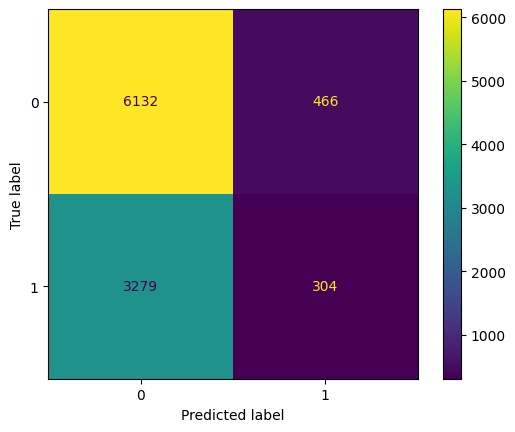

In [135]:
pipeline_voting_2.fit(X_train, y_train)

y_test_pred=pipeline_voting_2.predict(X_test)

print(pipeline_voting_2.score(X_train,y_train))
print(pipeline_voting_2.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_voting_2.classes_).plot()

In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      6598
           1       0.36      0.35      0.35      3583

    accuracy                           0.55     10181
   macro avg       0.51      0.51      0.51     10181
weighted avg       0.55      0.55      0.55     10181



#### Rééquilibrage de classes, méthode SMOTE

In [4]:
from imblearn.over_sampling import SMOTE

In [6]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Month', 'SumRank', 'SumOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])
preprocessor

ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                 ['GapRank', 'GapOdd', 'Month', 'SumRank',
                                  'SumOdd']),
                                ('encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Location', 'Tournament', 'Series', 'Court',
                                  'Surface', 'Round'])])

In [7]:
X=preprocessor.fit_transform(X)
# X_test_scaled=preprocessor.transform(X_test)

In [8]:
smote=SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_l2m)

In [11]:
y_l2m.value_counts()

L2M
0    26331
1    14392
Name: count, dtype: int64

In [9]:
y_resampled.value_counts()

L2M
0    26331
1    26331
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

In [ ]:
# categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
# numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

# rob_scaler = RobustScaler()
# ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('none', rob_scaler, numeric_columns),
#         ('encoder', ohe, categorical_columns)
#     ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_bernoulli = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BernoulliNB())
])

pipeline_bernoulli

0.8542637229086489
0.622816345131399


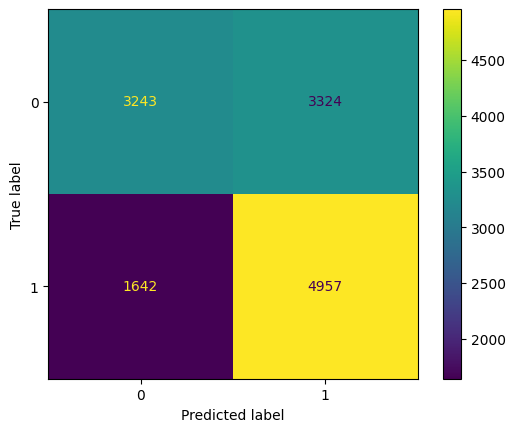

In [27]:
algo=VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()), 
    ('gauss', GaussianNB()), 
    ('dt', DecisionTreeClassifier())], 
                             voting='hard')

algo.fit(X_train, y_train)
y_test_pred=algo.predict(X_test)

print(algo.score(X_train,y_train))
print(algo.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=algo.classes_).plot()

## PREDICTIONS SUR NB DE JEUX

In [178]:
X=df.drop(columns=['Date', 'Winner', 'Loser', 'Comment', 'ATP', 'Best of', 
                   'WRank', 'LRank', 'B365W', 'B365L','W1', 'L1', 'W2', 'L2',  'W3', 'L3', 
                   'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'FavRank', 'FavOdd', 
                   'TotalSets', 'TotalGames', 'TotalWgames', 'TotalLgames', 'L2M'])

# y_rank=df['FavRank']
# y_odd=df['FavOdd']
# y_sets=df['TotalSets']
y_games=df['TotalGames']
# y_l2m=df['L2M']

In [179]:
X.columns

Index(['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'GapRank', 'GapOdd', 'Month'],
      dtype='object')

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y_games, test_size=0.25, random_state=42)

#### VotingRegressor

In [181]:
algo_voting=VotingRegressor(estimators=[
    ('knn', ElasticNet()), 
    ('lr', LinearRegression()), 
    ('dt', DecisionTreeRegressor())])

In [191]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_voting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', algo_voting)
])

pipeline_voting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor',
                 VotingRegressor(estimators=[('knn', ElasticNet()),
                                             ('lr', LinearRegression()),
                                             ('dt',
                                              DecisionTreeRegressor())]))])

In [192]:
pipeline_voting.fit(X_train, y_train)

y_train_pred=pipeline_voting.predict(X_train)
y_test_pred=pipeline_voting.predict(X_test)

print(pipeline_voting.score(X_train,y_train))
print(pipeline_voting.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.5634773831081765
-0.0915043434610705
rmse train : 1.9165541456701
rmse test : 3.0184140952973824


In [184]:
y_test

37012    26.0
35704    16.0
2813     23.0
29602    19.0
37097    16.0
         ... 
14916    19.0
25591    18.0
30863    16.0
6232     17.0
28923    20.0
Name: TotalGames, Length: 10186, dtype: float64

In [193]:
pipeline_voting.predict(X_test)

array([19.24589895, 20.67770233, 19.66630911, ..., 21.6169927 ,
       19.47115937, 19.90149791])

In [194]:
df_pred=pd.DataFrame()
df_pred['target']=y_test
df_pred['voting']=pipeline_voting.predict(X_test)

#### Boosting

##### Clairement pas approprié pour la régression sur le nb de jeux => toutes les prédictions sont concentrés sur un intervalle de 12 à 22 jeux

In [195]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_adaboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier())
])

pipeline_adaboost

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', AdaBoostClassifier())])

In [196]:
pipeline_adaboost.fit(X_train, y_train)

y_train_pred=pipeline_adaboost.predict(X_train)
y_test_pred=pipeline_adaboost.predict(X_test)

print(pipeline_adaboost.score(X_train,y_train))
print(pipeline_adaboost.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse train :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.13493699885452462
0.1353818967209896
rmse train : 3.2947248614935774
rmse train : 3.2943644648956574


In [197]:
pipeline_adaboost.predict(X_test)

array([19., 19., 19., ..., 19., 19., 19.])

In [198]:
df_pred['adaboost']=pipeline_adaboost.predict(X_test)

#### Bagging

In [199]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_bagging = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingRegressor(LinearRegression()))
])

pipeline_bagging

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 BaggingRegressor(base_estimator=LinearRegression()))])

In [200]:
pipeline_bagging.fit(X_train, y_train)

y_train_pred=pipeline_bagging.predict(X_train)
y_test_pred=pipeline_bagging.predict(X_test)

print(pipeline_bagging.score(X_train,y_train))
print(pipeline_bagging.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.043988495600860045
0.023170449826924067
rmse train : 2.8362811424013996
rmse test : 2.8554560537319786


In [201]:
pipeline_bagging.predict(X_test)

array([20.02629089, 20.33145294, 20.33387604, ..., 20.07637329,
       19.65311279, 20.99126282])

In [202]:
df_pred['bagging']=pipeline_bagging.predict(X_test)

#### LinearRegression

In [204]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_linearreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

pipeline_linearreg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', LinearRegression())])

In [205]:
pipeline_linearreg.fit(X_train, y_train)

y_train_pred=pipeline_linearreg.predict(X_train)
y_test_pred=pipeline_linearreg.predict(X_test)

print(pipeline_linearreg.score(X_train,y_train))
print(pipeline_linearreg.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.044870758656127
0.024611107369835405
rmse train : 2.834972097662414
rmse test : 2.8533496206363798


In [206]:
df_pred['linearreg']=pipeline_linearreg.predict(X_test)

#### LinearReg fine tuned

In [280]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_linearreg_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression(fit_intercept=False, positive=False))
])

pipeline_linearreg_gs

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', LinearRegression(fit_intercept=False))])

In [281]:
pipeline_linearreg_gs.fit(X_train, y_train)

y_train_pred=pipeline_linearreg_gs.predict(X_train)
y_test_pred=pipeline_linearreg_gs.predict(X_test)

print(pipeline_linearreg_gs.score(X_train,y_train))
print(pipeline_linearreg_gs.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.0448844696652414
0.024578794513966717
rmse train : 2.834951749385927
rmse test : 2.853396883380574


In [282]:
df_pred['linearreg_gs']=pipeline_linearreg_gs.predict(X_test)

#### DecisionTree

In [254]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor())
])

pipeline_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', DecisionTreeRegressor())])

In [255]:
pipeline_dt.fit(X_train, y_train)

y_train_pred=pipeline_dt.predict(X_train)
y_test_pred=pipeline_dt.predict(X_test)

print(pipeline_dt.score(X_train,y_train))
print(pipeline_dt.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.9858897214273334
-0.9579019183889546
rmse train : 0.3445763863825751
rmse test : 4.042607264527596


In [210]:
df_pred['decisiontree']=pipeline_dt.predict(X_test)

#### RandomForest

In [211]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', RandomForestRegressor())])

In [212]:
pipeline_rf.fit(X_train, y_train)

y_train_pred=pipeline_rf.predict(X_train)
y_test_pred=pipeline_rf.predict(X_test)

print(pipeline_rf.score(X_train,y_train))
print(pipeline_rf.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.8384910476211119
-0.10162525647100229
rmse train : 1.1657784375939368
rmse test : 3.032375843080512


In [213]:
df_pred['randomforest']=pipeline_rf.predict(X_test)

#### GradientBoosting

In [214]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_gradientboosting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

pipeline_gradientboosting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', GradientBoostingRegressor())])

In [215]:
pipeline_gradientboosting.fit(X_train, y_train)

y_train_pred=pipeline_gradientboosting.predict(X_train)
y_test_pred=pipeline_gradientboosting.predict(X_test)

print(pipeline_gradientboosting.score(X_train,y_train))
print(pipeline_gradientboosting.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.050221732547882314
0.02846881692970471
rmse train : 2.827019682697601
rmse test : 2.8477014635471276


In [216]:
df_pred['gradientboosting']=pipeline_gradientboosting.predict(X_test)

#### SGDRegressor

In [286]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_sgd = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor())
])

pipeline_sgd

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', SGDRegressor())])

In [287]:
pipeline_sgd.fit(X_train, y_train)

y_train_pred=pipeline_sgd.predict(X_train)
y_test_pred=pipeline_sgd.predict(X_test)

print(pipeline_sgd.score(X_train,y_train))
print(pipeline_sgd.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.04045366638412473
0.029777118317138807
rmse train : 2.8415198445441856
rmse test : 2.845783405247734


In [288]:
df_pred['sgd']=pipeline_sgd.predict(X_test)

#### Naive Bayes

In [292]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GaussianNB())
])

pipeline_nb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', GaussianNB())])

In [293]:
pipeline_nb.fit(X_train, y_train)

y_train_pred=pipeline_nb.predict(X_train)
y_test_pred=pipeline_nb.predict(X_test)

print(pipeline_nb.score(X_train,y_train))
print(pipeline_nb.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.016363933889707086
0.009621048497938347
rmse train : 6.9716399580582635
rmse test : 6.942387242468286


In [294]:
df_pred['naive_bayes']=pipeline_nb.predict(X_test)

#### GridSearch

In [223]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])
preprocessor

ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                 ['GapRank', 'GapOdd', 'Month']),
                                ('encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Location', 'Tournament', 'Series', 'Court',
                                  'Surface', 'Round'])])

In [225]:
X_train_scaled=preprocessor.fit_transform(X_train)
X_test_scaled=preprocessor.transform(X_test)

In [277]:
lr=LinearRegression()
dico_lr={'fit_intercept' : [True, False],
         'positive' : [True, False]
         }

gs= GridSearchCV(lr, dico_lr)

gs.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]})

In [278]:
gs.best_params_

{'fit_intercept': False, 'positive': False}

In [279]:
gs.best_score_

0.026349071215370556

#### DecisionTree fine tuned

In [273]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_dt_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=2, splitter='best'))
])

pipeline_dt_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', DecisionTreeRegressor(max_depth=5))])

In [274]:
pipeline_dt_best.fit(X_train, y_train)

y_train_pred=pipeline_dt_best.predict(X_train)
y_test_pred=pipeline_dt_best.predict(X_test)

print(pipeline_dt_best.score(X_train,y_train))
print(pipeline_dt_best.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.0354716823198955
0.017810647460503648
rmse train : 2.848886908826765
rmse test : 2.8632791911238833


In [275]:
df_pred['decisiontree_gs']=pipeline_dt_best.predict(X_test)

#### Comparatifs prédictions

In [298]:
pipeline_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', DecisionTreeRegressor())])

In [295]:
df_pred.describe()

,target,voting,adaboost,bagging,linearreg,decisiontree,randomforest,gradientboosting,decisiontree_gs,linearreg_gs,sgd,naive_bayes
count,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000,10186.000000
mean,19.623601,19.701943,18.755841,19.713189,19.710212,19.697019,19.718747,19.716697,19.715740,19.710361,19.700528,15.379148
std,2.889265,1.061164,1.297245,0.662761,0.646010,2.967369,1.195062,0.500989,0.544103,0.645354,0.653186,4.760290
min,12.000000,15.838672,12.000000,12.904654,12.832031,12.000000,14.910000,16.793316,15.333333,12.857788,10.977321,12.000000
25%,17.000000,18.925139,19.000000,19.364346,19.368164,17.000000,18.974750,19.461664,19.512565,19.370390,19.354820,13.000000
50%,19.000000,19.641732,19.000000,19.759927,19.754883,20.000000,19.700000,19.785152,20.023737,19.753475,19.774486,13.000000
75%,22.000000,20.471892,19.000000,20.116046,20.117615,22.000000,20.446250,20.051926,20.023737,20.116333,20.137135,14.000000
max,34.000000,28.582487,22.000000,29.101434,27.633301,39.000000,37.460000,32.316785,40.333333,27.642700,22.048825,26.000000


<AxesSubplot:>

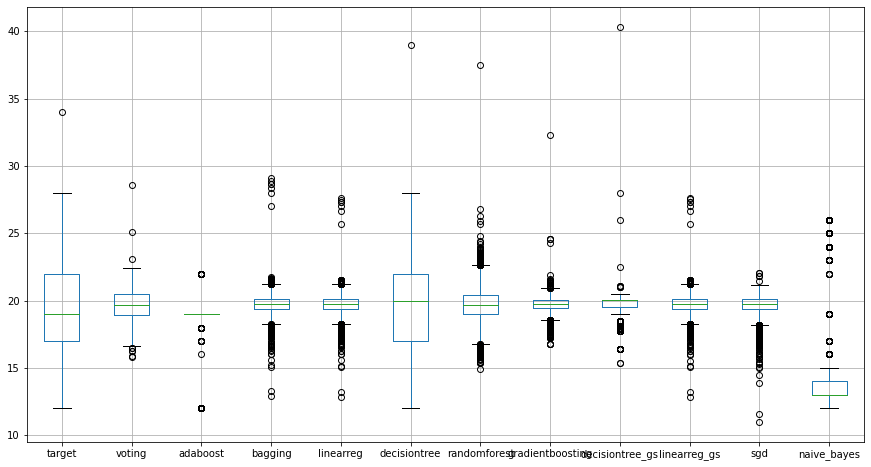

In [297]:
df_pred.boxplot(figsize=(15,8))

In [251]:
pipeline_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 DecisionTreeRegressor(criterion='poisson', max_depth=3,
                                       min_samples_split=8))])

In [263]:
test=X_test.sample(n=1)
test

,Location,Tournament,Series,Court,Surface,Round,GapRank,GapOdd,Month
19785,Chennai,Chennai Open,ATP250,Outdoor,Hard,1st Round,168.0,1.18,1


In [264]:
pipeline_dt.predict(test)

array([15.])

In [265]:
df.iloc[19785]

ATP                       2
Location            Chennai
Tournament     Chennai Open
Date             2012-01-03
Series               ATP250
Court               Outdoor
Surface                Hard
Round             1st Round
Best of                   3
Winner            Sugita Y.
Loser             Rochus O.
WRank                 235.0
LRank                  67.0
W1                      6.0
L1                      3.0
W2                      6.0
L2                      4.0
W3                      NaN
L3                      NaN
W4                      NaN
L4                      NaN
W5                      NaN
L5                      NaN
Wsets                   2.0
Lsets                   0.0
Comment           Completed
B365W                  2.62
B365L                  1.44
FavRank                   1
FavOdd                  1.0
GapRank               168.0
GapOdd                 1.18
TotalSets               2.0
TotalWgames            12.0
TotalLgames             7.0
TotalGames          

In [356]:
# Sérialisation du modèle
with open('pipeline_3sets_nbgames.pkl', 'wb') as fichier:
    pickle.dump(pipeline_dt, fichier)

In [352]:
df.corr()

,ATP,Best of,WRank,LRank,W1,L1,W2,L2,W4,L4,...,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames,L2M,Month
ATP,1.000000,NaN,-0.035287,-0.028637,0.004419,0.020060,0.001009,0.017264,8.057275e-02,-0.107640,...,-0.000444,0.000752,-0.016391,-0.014958,0.010168,0.004486,0.026200,0.026086,0.009946,0.951455
Best of,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WRank,-0.035287,NaN,1.000000,0.123493,-0.024528,0.044499,-0.024791,0.035633,-2.938292e-01,0.361674,...,0.420475,0.305414,0.356296,-0.177598,0.046099,-0.038231,0.055738,0.029463,0.046847,-0.032070
LRank,-0.028637,NaN,0.123493,1.000000,0.014863,-0.061336,0.025355,-0.058780,-1.157812e-01,0.032190,...,-0.291894,-0.224680,0.845391,0.188368,-0.051892,0.030030,-0.084174,-0.059592,-0.051420,-0.028105
W1,0.004419,NaN,-0.024528,0.014863,1.000000,-0.189980,-0.143922,0.069450,6.734387e-01,-0.565779,...,-0.035740,-0.053831,0.007640,0.031670,-0.486079,0.664978,-0.083058,0.287426,-0.486936,0.006295
L1,0.020060,NaN,0.044499,-0.061336,-0.189980,1.000000,0.099669,0.021172,-3.291869e-01,0.230022,...,0.089016,0.119636,-0.039788,-0.121431,0.409576,-0.071508,0.708414,0.600284,0.410325,0.017525
W2,0.001009,NaN,-0.024791,0.025355,-0.143922,0.099669,1.000000,-0.196006,-3.431948e-01,0.552052,...,-0.035536,-0.048525,0.014111,0.029368,-0.446434,0.639553,-0.069203,0.286073,-0.447161,0.000729
L2,0.017264,NaN,0.035633,-0.058780,0.069450,0.021172,-0.196006,1.000000,6.907747e-01,-0.858395,...,0.080746,0.110144,-0.037351,-0.099686,0.396468,-0.093147,0.719750,0.598720,0.397307,0.017843
W4,0.080573,NaN,-0.293829,-0.115781,0.673439,-0.329187,-0.343195,0.690775,1.000000e+00,-0.652482,...,-0.276825,-0.046984,0.214512,0.364984,-0.628491,-0.139934,-0.593903,-0.461747,NaN,0.096289
L4,-0.107640,NaN,0.361674,0.032190,-0.565779,0.230022,0.552052,-0.858395,-6.524823e-01,1.000000,...,0.404061,0.154303,-0.374416,-0.199361,0.576018,0.447145,0.724462,0.699900,NaN,0.045175


<AxesSubplot:>

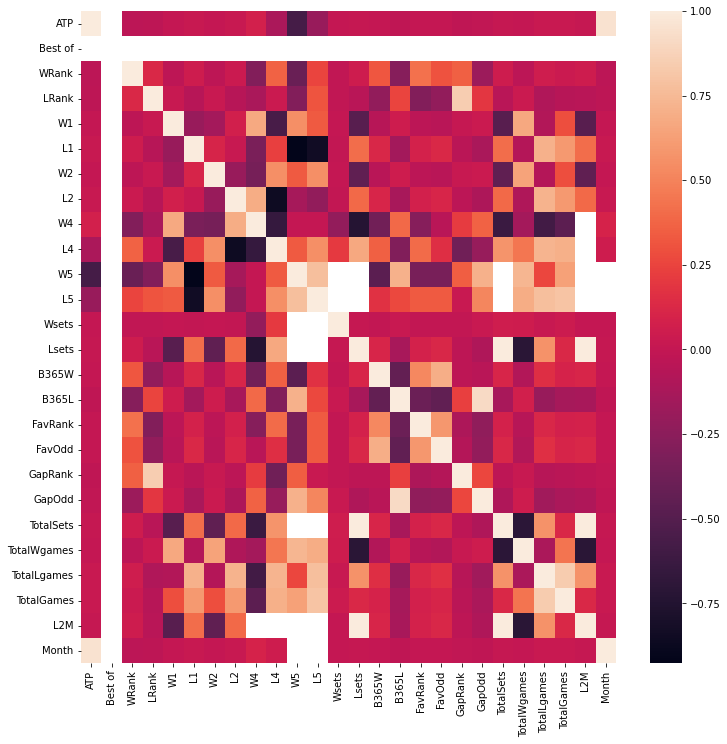

In [349]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr())

## PREDICTIONS SUR TOTALSETS

In [3]:
X=df.drop(columns=['Date', 'Winner', 'Loser', 'Comment', 'ATP', 'Best of', 
                   'WRank', 'LRank', 'B365W', 'B365L','W1', 'L1', 'W2', 'L2',  'W3', 'L3', 
                   'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'FavRank', 'FavOdd', 
                   'TotalSets', 'TotalGames', 'TotalWgames', 'TotalLgames', 'L2M'])

# y_rank=df['FavRank']
# y_odd=df['FavOdd']
y_sets=df['TotalSets']
# y_games=df['TotalGames']
# y_l2m=df['L2M']

In [4]:
X.columns

Index(['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'GapRank', 'GapOdd', 'Month', 'SumOdd', 'SumRank'],
      dtype='object')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sets, test_size=0.25, random_state=42)

In [6]:
df_pred_sets = pd.DataFrame()
df_pred_sets['real'] = y_test

In [35]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

#### Voting

In [36]:
algo_voting=VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()), 
    ('lr', LogisticRegression()), 
    ('dt', DecisionTreeClassifier())], 
                             voting='hard')

In [37]:
# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_voting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', algo_voting)
])

pipeline_voting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                                              ('lr', LogisticRegression()),
                                              ('dt',
                                               DecisionTreeClassifier())]))])

0.8069543579333377
0.615067282192319


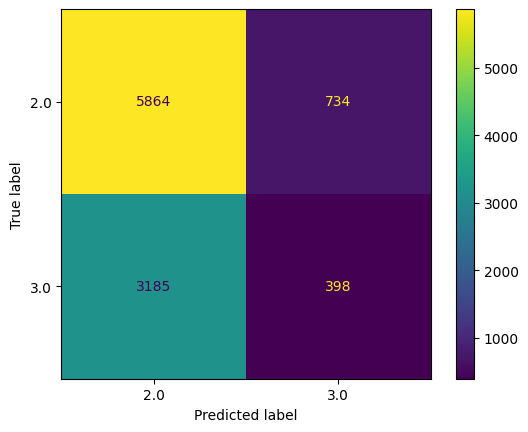

In [38]:
pipeline_voting.fit(X_train, y_train)

y_test_pred=pipeline_voting.predict(X_test)

print(pipeline_voting.score(X_train,y_train))
print(pipeline_voting.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_voting.classes_).plot()

In [39]:
df_pred_sets['voting'] = pipeline_voting.predict(X_test)

#### plusieurs algos

In [7]:
base_model = DecisionTreeClassifier(max_depth=3)

algos = [LogisticRegression(), 
         DecisionTreeClassifier(), 
         KNeighborsClassifier(),
         RandomForestClassifier(), 
         AdaBoostClassifier(), 
         GradientBoostingClassifier(),
         GaussianNB(),
         BernoulliNB()]

In [8]:
score_train=[]
score_test=[]

for algo in algos:
    categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
    numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

    rob_scaler = RobustScaler()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    # Création du préprocesseur pour les colonnes numériques et catégorielles
    preprocessor = ColumnTransformer(
        transformers=[
            ('rob_scaler', rob_scaler, numeric_columns),
            ('encoder', ohe, categorical_columns)
        ])

    # Création du pipeline avec le préprocesseur et le classificateur SVC
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', algo)
    ])
    
    pipeline.fit(X_train, y_train)
    score_train.append(pipeline.score(X_train,y_train))
    score_test.append(pipeline.score(X_test,y_test))   

In [9]:
score_train

[0.6463230960644358,
 0.9997380656145636,
 0.7203195599502324,
 0.9997380656145636,
 0.6465850304498723,
 0.648156636762491,
 0.5011459629362844,
 0.6375482941523148]

In [10]:
score_test

[0.6464001571554857,
 0.5612415283370985,
 0.5825557410863373,
 0.597681956585797,
 0.6466948236911895,
 0.6474806011197328,
 0.4721540123759945,
 0.6319614969060013]

#### DecisionTree

In [30]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

pipeline_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', DecisionTreeClassifier())])

0.9997380656145636
0.5574108633729496


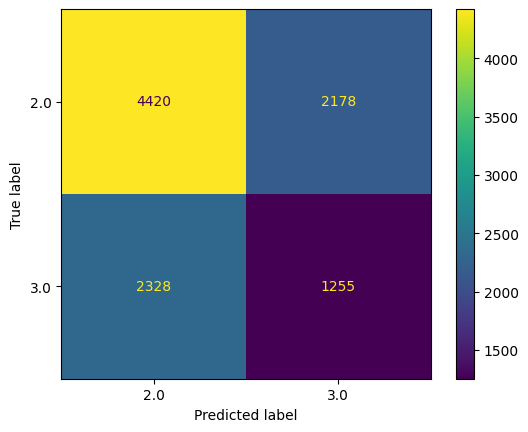

In [31]:
pipeline_dt.fit(X_train, y_train)

y_test_pred=pipeline_dt.predict(X_test)

print(pipeline_dt.score(X_train,y_train))
print(pipeline_dt.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_dt.classes_).plot()

#### RandomForest

In [13]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', RandomForestClassifier())])

0.9997380656145636
0.5966997348001178


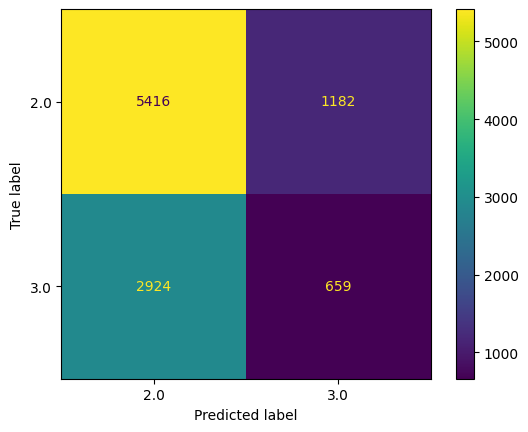

In [14]:
pipeline_rf.fit(X_train, y_train)

y_test_pred=pipeline_rf.predict(X_test)

print(pipeline_rf.score(X_train,y_train))
print(pipeline_rf.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_rf.classes_).plot()

#### Gradient Boosting

In [7]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_gradientboosting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

pipeline_gradientboosting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', GradientBoostingClassifier())])

0.648156636762491
0.6474806011197328


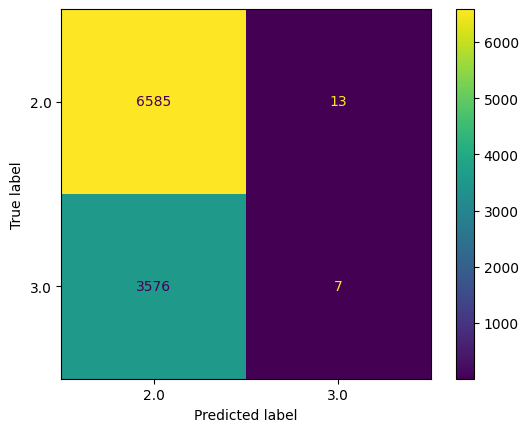

In [8]:
pipeline_gradientboosting.fit(X_train, y_train)

y_test_pred=pipeline_gradientboosting.predict(X_test)

print(pipeline_gradientboosting.score(X_train,y_train))
print(pipeline_gradientboosting.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_gradientboosting.classes_).plot()

#### GridSearch

In [18]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Month', 'SumRank', 'SumOdd']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])
preprocessor

ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                 ['GapRank', 'GapOdd', 'Month', 'SumRank',
                                  'SumOdd']),
                                ('encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Location', 'Tournament', 'Series', 'Court',
                                  'Surface', 'Round'])])

In [19]:
X_train_scaled=preprocessor.fit_transform(X_train)
X_test_scaled=preprocessor.transform(X_test)

In [28]:
dt=DecisionTreeClassifier()
dico_dt={'criterion':['gini'],
         'max_depth': [3, 5],
         'min_samples_leaf':[1, 2,3,4]
         }

gs= GridSearchCV(dt, dico_dt)

gs.fit(X_train_scaled, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [3, 5],
                         'min_samples_leaf': [1, 2, 3, 4]})

In [25]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}

In [26]:
gs.best_score_

0.6451115957936389

#### DecisionTree Hypertuné

In [27]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='gini', 
                                          max_depth=3,
                                          min_samples_split=2))
])

pipeline_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

0.6462248706698972
0.6471859345840291


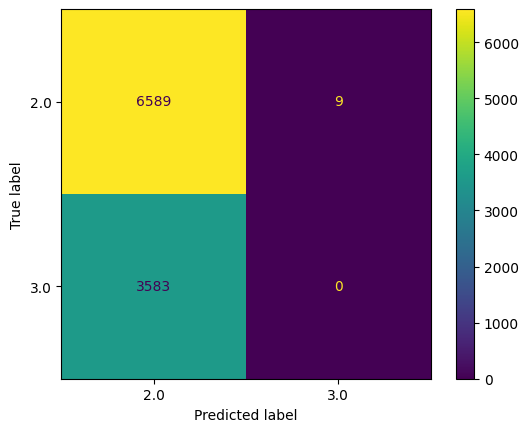

In [29]:
pipeline_dt.fit(X_train, y_train)

y_test_pred=pipeline_dt.predict(X_test)

print(pipeline_dt.score(X_train,y_train))
print(pipeline_dt.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_dt.classes_).plot()

#### GaussianNB

In [32]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_gauss = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

pipeline_gauss

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', GaussianNB())])

0.5011459629362844
0.4721540123759945


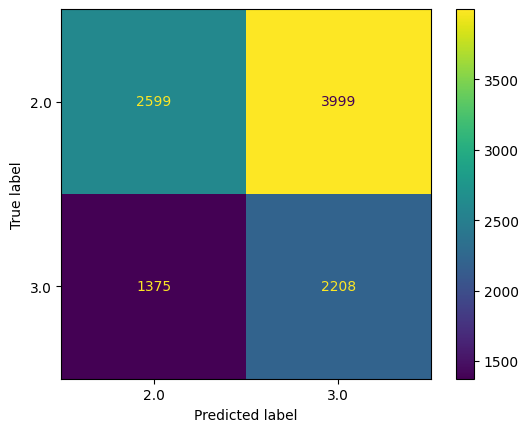

In [33]:
pipeline_gauss.fit(X_train, y_train)

y_test_pred=pipeline_gauss.predict(X_test)

print(pipeline_gauss.score(X_train,y_train))
print(pipeline_gauss.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=pipeline_gauss.classes_).plot()

#### Stacking

In [12]:
from mlxtend.classifier import StackingClassifier


# Initialize individual models
clf_1 = GaussianNB()
clf_2 = KNeighborsClassifier()
clf_3 = DecisionTreeClassifier()
clf_meta = LogisticRegression() # Initialize meta-model
clf_stack = StackingClassifier(classifiers=[clf_1, clf_2, clf_3], # Create stacking classifier
                               meta_classifier=clf_meta, 
                               use_probas=True, 
                               use_features_in_secondary=True)

   
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumRank', 'SumOdd']
rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_stacking = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf_stack)])
    

pipeline_stacking
   

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumRank', 'SumOdd']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 StackingClassifier(classifiers=[GaussianNB(),
                                                 KNeighborsClassifier(),
                                                 DecisionTreeClassifier()],
                                    meta_classifier=LogisticRegression(),
                                    use_features_in_secondary=True,
                                    use_probas=True))])

0.9997380656145636
0.5530890875159611


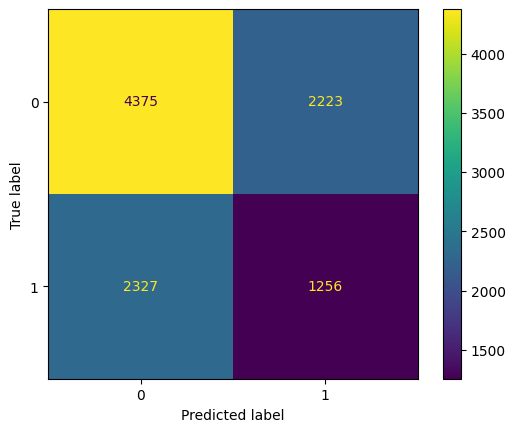

In [13]:
pipeline_stacking.fit(X_train, y_train)

y_test_pred=pipeline_stacking.predict(X_test)

print(pipeline_stacking.score(X_train,y_train))
print(pipeline_stacking.score(X_test,y_test))

ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=[0,1]).plot()

In [46]:
test=X_test.sample(n=1)
test

,Location,Tournament,Series,Court,Surface,Round,GapRank,GapOdd,Month,SumOdd,SumRank
18517,Belgrade,Serbia Open,ATP250,Outdoor,Clay,2nd Round,479.0,1.18,4,4.06,553.0


In [47]:
df.iloc[[18517]]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames,L2M,Month,SumOdd,SumRank
18517,25,Belgrade,Serbia Open,2011-04-27,ATP250,Outdoor,Clay,2nd Round,3,Lopez F.,Gonzalez F.,37.0,516.0,6.0,4.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.44,2.62,0,0.0,479.0,1.18,2.0,13.0,10.0,23.0,0,4,4.06,553.0


In [48]:
pipeline_stacking.predict(test)

array([2.])

In [49]:
pipeline_stacking.predict_proba(test)

array([[9.99553015e-01, 4.46984684e-04]])

#### Sérialisation

In [51]:
# Sérialisation du modèle
with open('pipeline_atp_3sets_nbsets.pkl', 'wb') as fichier:
    pickle.dump(pipeline_stacking, fichier)